In [83]:
# Packages
import pickle
from community import community_louvain
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import itertools
from fa2 import ForceAtlas2
from operator import itemgetter

In [2]:
# Load data
super_hero_dict = pickle.load( open( "../Data/super_hero_dict_formatted.pickle", "rb" ) )

# Read undirected graph based on GCC
G = nx.read_gpickle("../Data/GCC_undirected.pickle")

G_marvel = G.subgraph([superhero for superhero, universe in nx.get_node_attributes(G, 'Universe').items() if universe == 'Marvel'])
G_dc = G.subgraph([superhero for superhero, universe in nx.get_node_attributes(G, 'Universe').items() if universe == 'DC'])

# Part 3: Communities and TF-IDF

In this part the structure of the graph will be investigated closer by looking at *communities* of the data. The optimal partition will be found using the *Louvain method*. Afterwards these communities will be considered as once entitiy and their wikitext will be treated as a single *document*. Based on this they can be charactarized based on the TF-IDF, where the collection of documents based on the communities are the corpus.

**Find the communities. Explain briefly how you chose to identify the communities: Which algorithm did you use, how does it work?**

In part 3 and 4 only the Marvel universe will be considered by using the `G_marvel` graph why the communities of this unvierse will be found. This partition will be found the the Louvain method. The algorithm works by iteratively going through the two following steps:

1) All nodes in the network are assigned to their own individual community. For all nodes $i$ the change in modulatiry is calculated when the node $i$ is moved into its neigbour $j$'s community. This is done for all neighbors of $i$ and $i$ is then moved into the community that leads to the greatest increase in modularity. If the modularity can not be increased $i$ stays. If no *merge* can lead to an increased modularity the algorithm terminates.

2) All nodes that now have become a community are merged into one node. The links between nodes in that community are made into self-loops while weighted links will be used to represent multiple links between a community. On this new graph step 1) can be applied again.

The method is used as it is quite simple to understand. By passing the argument `randomize = False` to the function it also becomes deterministic which is nice for reproduceability. With the `community_louvain.best_partition` function the optimal partition can also be calculated very fast, which is off course also nice.

The partition is calculated below where the output also is shown:

In [67]:
communitiesMarvel = community_louvain.best_partition(G_marvel, randomize = False)

# Show data structure
communitiesMarvel

{'A-Bomb': 0,
 'Abomination': 1,
 'Ajak': 2,
 'Ajax': 2,
 'Amphibius': 3,
 'Anansi': 3,
 'Anelle': 1,
 'Arishem the Judge': 1,
 'Avoe': 1,
 'Brian Banner': 4,
 'Banshee': 5,
 'Barbarus': 3,
 'Baron Blood': 0,
 'Baron Brimstone': 6,
 'Baron Mordo': 7,
 'Baron Strucker': 0,
 'Baron Zemo': 0,
 'Barracuda': 1,
 'Breeze Barton': 4,
 'Bast': 6,
 'Bastion': 5,
 'Batroc the Leaper': 0,
 'Battlestar': 6,
 'Batwing': 4,
 'Beast': 5,
 'Beautiful Dreamer': 5,
 'Bedlam': 3,
 'Beef': 5,
 'Beetle': 3,
 'Belasco': 6,
 'Bella Donna': 6,
 'Bengal': 1,
 'Bereet': 1,
 'Berzerker': 5,
 'Beta Ray Bill': 1,
 'Beyonder': 1,
 'Bi-Beast': 4,
 'Big Bertha': 4,
 'Big Man': 3,
 'Big Wheel': 3,
 'Bird-Man': 6,
 'Bishop': 5,
 'Black Ant': 0,
 'Black Bolt': 1,
 'Black Box': 6,
 'Black Cat': 3,
 'Black Crow': 7,
 'Black Dwarf': 1,
 'Black Jack Tarr': 3,
 'Black Knight': 0,
 'Black Mamba': 6,
 'Black Marvel': 6,
 'Black Panther': 0,
 'Black Racer': 6,
 'Black Rider': 4,
 'Black Spectre': 3,
 'Black Swan': 1,
 'Black Ta

Now this dictionaty is *reversed* so it is possible to easily find the nodes, i.e. super heroes, that belongs to a given community. The output is also illustrated:

In [68]:
communities_dict = {c: [k for k,v in communitiesMarvel.items() if v == c] 
                    for c in set(communitiesMarvel.values())}

# Show data structure
communities_dict

{0: ['A-Bomb',
  'Baron Blood',
  'Baron Strucker',
  'Baron Zemo',
  'Batroc the Leaper',
  'Black Ant',
  'Black Knight',
  'Black Panther',
  'Blacklash',
  'Blank',
  'Blizzard',
  'Bloodshed',
  'Blue Eagle',
  'Calamity',
  'Capricorn',
  'Carnivore',
  'Challenger',
  'Chemistro',
  'Cheshire Cat',
  'Cobalt Man',
  'Coldblood',
  'Comanche',
  'Conquest',
  'Controller',
  'Crimson Dynamo',
  'Crossbones',
  'Crusher',
  'Darkstar',
  'Deathlok',
  'Detroit Steel',
  'Digitek',
  'Doc Samson',
  'Doctor Spectrum',
  'Dracula',
  'Dreadknight',
  'Dreadnought',
  'Egghead',
  'Enchantress',
  'Falcon',
  'Firepower',
  'Fixer',
  'Flying Tiger',
  'Force',
  'Foxfire',
  'Freak',
  'Friday',
  'Friction',
  'Ghost',
  'Giant-Man',
  'GoGo Tomago',
  'Golden Archer',
  'Goliath',
  'Grasshopper',
  'Griffin',
  'Grim Reaper',
  'Guardsman',
  'Hate-Monger',
  'Haywire',
  'Hermes',
  'Happy Hogan',
  'Hollywood',
  'Honey Lemon',
  'Human Top',
  'Hyperion',
  'Hypnotia',
  'Immo

Let's also have a look at resulting modularity of the partition

In [69]:
nx.algorithms.community.quality.modularity(G_marvel, list(communities_dict.values()))

0.3697382073255283

An ideal modularity is 1 but this is not expected to be seen in an real network. When considering the structure of the network of a single universe - as illustrated in part 1 - it is very connected and it is hard to come by well seperated communities. Therefore the modularity of $Q=0.37$ is not unexpected as the optimal found by the Lauvain method.

**How many communities did you find in total?**

This is calculated as the number of elements in the `communities_dict`:

In [72]:
len(communities_dict)

20

A total of 20 communities are found which that there are around 67 nodes on average in a community. The fact that relatively many are found.also support the point stated above where there are not really many well seperated communities.

**Plot the distribution of community sizes.**

Even though the average of around 67 nodes per community easily are calculated it is interesting to look at the actual distribution of community sizes. This is easily done in a bar plot based on the `communities_dict` where the number of super heroes in a community becomes the height. This is done below:

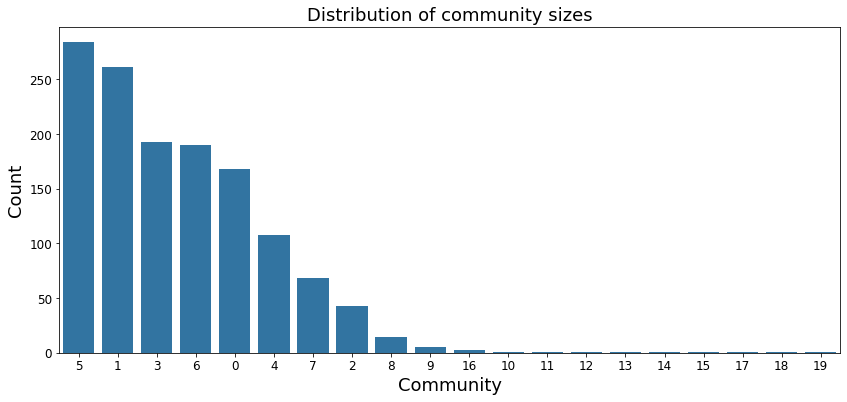

In [79]:
# List to sort according to size
com_size_order = sorted(communities_dict, key = lambda k: len(communities_dict[k]), reverse = True)

plt.figure(figsize = (14,6))
sns.barplot(
    x = list(communities_dict.keys()), 
    y = [len(com) for com in communities_dict.values()], 
    order = com_size_order,
    color = "tab:blue"
)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Community", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
plt.title("Distribution of community sizes", fontsize = 18)
plt.show()

By looking at this plot it is very clear that the distribution is no way near uniform. Some communnities ends up with more than 250 nodes there is also a handfull with very few nodes - so few the bar plot is not really help full. Thus let's just have a look at the actual numbers which is shown below:

In [105]:
sorted([len(com) for com in communities_dict.values()], reverse = True)

[284, 261, 193, 190, 168, 108, 68, 43, 14, 5, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]

From this list it can be verified that nine communities only have one node - which may could be isolated nodes. The easiest way to inspect the actual structure is by visualizing the communities which is done below. Here [this list](https://sashamaps.net/docs/resources/20-colors/) is used to get 20 *distinct* colors, where a dict that maps from community to color is defined below. More over the communities with only one node are extracted so these nodes can be emphasized in the plot.

In [114]:
# Color dict from https://sashamaps.net/docs/resources/20-colors/
color_dict = {0: '#e6194B', 1: '#3cb44b', 2: '#ffe119', 3:'#4363d8', 4:'#f58231', 5:'#911eb4', 
              6:'#42d4f4', 7:'#f032e6', 8:'#bfef45', 9:'#fabed4', 10:'#469990', 11:'#dcbeff', 
              12:'#9A6324', 13:'#fffac8', 14:'#800000', 15:'#aaffc3', 16:'#808000', 17:'#ffd8b1', 
              18:'#000075',19:'#515151'
             }

# Communities with only one node
single_coms = [k for k,v in communities_dict.items() if len(v) == 1]

`ForceAtlas2` is used to illustrate the graph is a very similar fashion as seen in `Part 1`. All can be seen below:

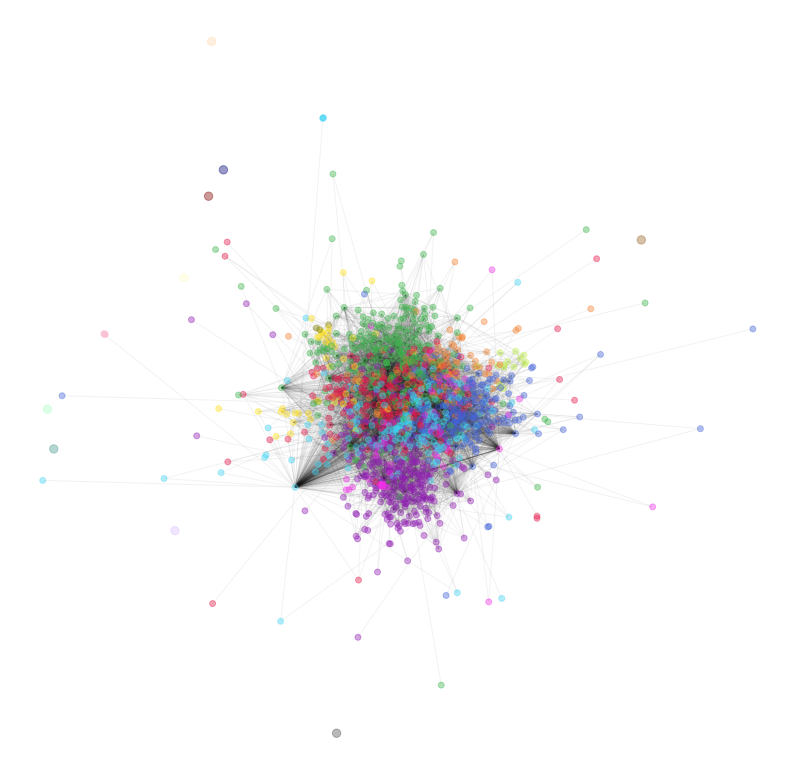

In [118]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    edgeWeightInfluence = 5.5, # Performance

    # Performance
    jitterTolerance=0.2,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,

    # Tuning
    scalingRatio=0.1,
    gravity=1.0,

    # Log
    verbose=False
)

# Calculate positions
positions = forceatlas2.forceatlas2_networkx_layout(G_marvel, pos=None, iterations=1000)
# Find node sizes
node_size = [70 if communitiesMarvel[char] in single_coms else 35 for char in G_marvel.nodes]
# Find node colors
node_color = [color_dict[communitiesMarvel[char]] for char in G_marvel.nodes]

plt.figure(figsize=(14,14))

# Plot nodes
nx.draw_networkx_nodes(
    G = G_marvel,
    node_size = node_size,
    pos = positions, 
    node_color= node_color,
    alpha=0.4
)

# Plot edges
nx.draw_networkx_edges(
    G = G_marvel,
    pos = positions, 
    edge_color = "k", 
    alpha=0.05
)
plt.axis('off')
plt.show()

As there are 20 different communities - and thus 20 different colors - the plot looks kind off messy. There are though still some take aways. It can be clearly seen that the 9 nodes in there own community are isolates (look after the larger nodes). Moreover it can also be seen that there are some structure in the colors in the large central cluster with green and purple nodes clearly comming together. To fully understand the communities one should off course look closer at the links but due to the size of the network it will not be investigated futer.

**For the 5-10 largest communities, create TF-IDF based rankings of words in each community.**

Now it is time to investigate the the communities based on the Wikipedia for the super heroes in each community. For this the 8 largest communities will be used where this number is choosen as there is a cut-off in community sizes from the 8<sup>th</sup> to the 9<sup>th</sup> largest community. From now on a *document* will where refer to the combined wikitext of all characters in a community and the *corpus* is the collection of these resulting 8 documents. 

The term frequency–inverse document frequency (tf-idf) method will be used to describe each community. This leads to words scoring high if they are seen many time in a document but are rare across documents in the corpus. In this case the *raw count* will be used for the term frequency. The adjustment for the document length is not considered as the later analysis only will look at important words relative to other words in the same document. I.e. TF-IDF values will not be considered between documents and thus normalization would be redundant.

The code below create all documents by joining all wikitexts in each community. The tokenizer from `Part 2` is reused to make all the documents into lists of words. Please notice that stemming has not been used here. Afterwards `nltk.FreqDist` is used to count the frequencies of all words in all documents. Dictionaries are used as data structures to keep track of the communities.

In [121]:
# Number of communities to consider
N = 8

# Make all documents
token_dict = {com: tokenizer.tokenize(
                " ".join([super_hero_dict[char]['Wiki_text'] for char in communities_dict[com] 
                if super_hero_dict[char]['Wiki_text'] is not None])
                ) for com in com_size_order[:N] 
             }

# Calculate the TF
TF_dict = {key: nltk.FreqDist(value) for key, value in token_dict.items()}

The next step is to calculate the inverse document frequency. First a list of all unqiue words across the corpus is created called `all_words`. Afterwards the idf can be calculated as follows:
$$\operatorname{idf}(t, D)=\log \frac{N}{|\{d \in D: t \in d\}|}$$
Here the smoothning versions are not considered as $n_t$ never will be zero, as the list of all words is generated from the documents them self. The caulculation is performed below - again usign a dictionary as data structure.

In [10]:
# List of all words
all_words = set(list(itertools.chain(*token_dict.values())))

# Calculate idf
idf = {key: np.log(N / sum([tf[key] > 0 
            for k, tf in TF_dict.items()])) 
            for key in all_words
      }

With this the tf-idf can now be calculated as follows:
$$\operatorname{tf-idf}(t, d, D)=\operatorname{tf}(t, d) \cdot \operatorname{idf}(t, D)$$
A `pandas` data frame is used for this where the rows are the documents (communities) and the columns are all the words. This data frame is then populated by looping over all words and documents. This exercise is done in Python 3.7 why the [assignment expression](https://www.python.org/dev/peps/pep-0572/) was not available to speed up the code.

In [140]:
# Storing TF-IDF in a dataframe
TF_IDF = pd.DataFrame(index = TF_dict.keys(), columns = all_words)

for word in TF_IDF.columns:
    for doc in TF_IDF.index:
        TF_IDF.loc[doc, word] = TF_dict[doc][word] * idf[word]
        

Let's have a look at the resulting data frame:

In [143]:
TF_IDF

,turmoil,Merryweather,Nuke,Probationary,assist,decries,gluttony,strengthened,Thrill,Glob,...,forever,Delphine,Abdicated,Chlorokinesis,malleability,09,Caravan,Regaining,Pteranodons,Danish
5,0,0,0.916291,6.90776,4.31978,0,1.60944,5.54518,0,24.0795,...,2.90087,4.60517,0,0,0,1.60944,0,0.916291,0,0
1,3.61192,0,0,0,4.63586,0,1.60944,0.693147,0,36.1192,...,2.45458,0,3.21888,2.30259,4.58145,0,0,0,0,2.30259
3,0,0,0.916291,0,5.47875,2.30259,0,0,0,0,...,0.223144,0,0,0,0,0,0,0,2.30259,0
6,0,11.5129,47.6471,0,2.21257,0,0,0,0,0,...,1.78515,0,0,0,0.916291,0,0,0,0,0
0,0,0,9.16291,0,4.5305,0,0,0,0,1.20397,...,1.78515,0,0,0,0.916291,0,0,0.916291,0,0
4,0,0,0,0,1.26433,0,0,1.38629,2.30259,0,...,0.892574,0,1.60944,0,0.916291,0,0,1.83258,0,0
7,0,0,0,0,0.737524,0,0,0.693147,0,0,...,0.223144,16.1181,0,0,0,0,2.30259,0,0,0
2,0,0,0,0,0.842884,0,0,0,0,0,...,0,0,0,0,0.916291,1.60944,0,0.916291,0,0


Here it can be seen that the 8 communities are liste as indecies with all the words as columns. With around 50.000 words it is hard to fully understand the data why wordclouds will be used in a minute. It is though somewhat apparant that words that occur in few documents (many zeros in the columns) have higher values where they appear due to the inverse document frequency.

When using tf-idf it is not necessary to explicit handle stop words as the formula does it by itself. It does this with the idf-part. If a word is found in all documents the idf becomes
$$\operatorname{idf}(t, D)=\log \frac{N}{|\{d \in D: t \in d\}|}=\log \frac{N}{N}=0,$$
as thus the tf-idf also becomes 0. Let's look for how many words this is the case:

In [153]:
len([k for k,v in idf.items() if v == 0])

1882

So for $1882/49688 \approx 4\%$ words the idf is zero since the word appears is all documents. Let's just look at these words:

In [157]:
[k for k,v in idf.items() if v == 0]

['humans',
 'steal',
 'throw',
 'devastated',
 'convinces',
 'Inhuman',
 'fight',
 'lost',
 'homage',
 'grandfather',
 'technology',
 'vengeance',
 'remains',
 'surprised',
 'guest',
 'gas',
 'remained',
 '2004',
 'machine',
 'battling',
 'not',
 'humanoid',
 'allowing',
 'seeking',
 'vengeful',
 'Central',
 'King',
 'slightly',
 'distances',
 'which',
 'regular',
 'real',
 'creating',
 'teleported',
 'Infinity',
 'will',
 'Witch',
 'with',
 'cast',
 'Lee',
 'skirmish',
 'fit',
 'variation',
 'facility',
 'involving',
 'Tony',
 'threat',
 'became',
 'reluctantly',
 'prompting',
 'takeover',
 'gang',
 'temporary',
 'conflict',
 'world',
 'who',
 'the',
 'skill',
 'creation',
 'recovering',
 'following',
 'Secret',
 'With',
 'allow',
 'characters',
 'actually',
 'Planet',
 'designed',
 'prevent',
 'supervillains',
 'seven',
 'owner',
 'date',
 'Evil',
 'breaks',
 'hopes',
 'agent',
 'encountered',
 'all',
 'Once',
 'granted',
 'man',
 'country',
 'framed',
 'time',
 'alone',
 'ancient',


So this is very interesting. The td-idf finds the usual stopwords (with, the, in etc.) but also more *domain specific stop words* as fight and vengeance. It may look surprising that all these words are found in all documents but by looking at the lengths of each document (as shown below) it becomes more reasonable.

In [161]:
[len(words) for words in token_dict.values()]

[805663, 590334, 477420, 310667, 371387, 177473, 122650, 77211]

**Create a word-cloud displaying the most important words in each community (according to TF-IDF)**

A wordcloud is now created for each document with weights based on the tf-idf. By using the `.to_dict(orient = 'records'))` method on the td-idf data frame dictionaries for each community can easily be extracted and then the wordcloud can be generated. All 8 are shown below:

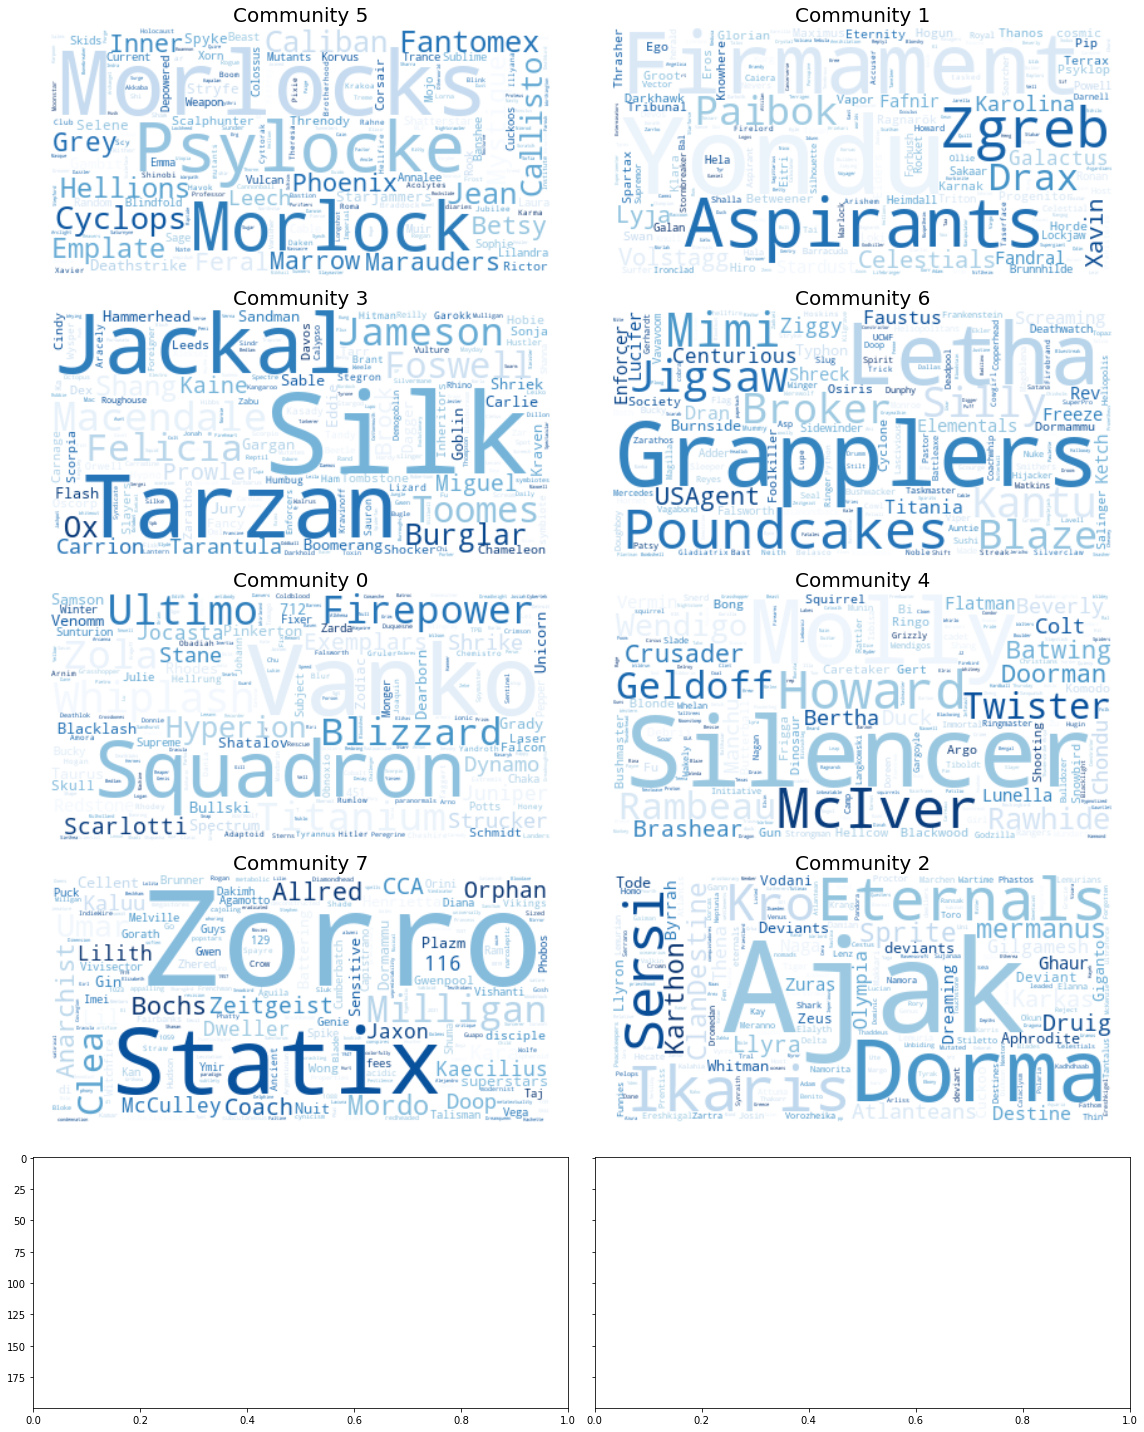

In [163]:
fig, axs = plt.subplots(N/2, 2, sharey=True, tight_layout=True, figsize = (16,20))

for p, (com, words) in enumerate(dict(zip(TF_IDF.index, TF_IDF.to_dict(orient = 'records'))).items()):
    import wordcloud
    wordcloud = wordcloud.WordCloud(colormap = "Blues", background_color = "white")
    wordcloud.generate_from_frequencies(frequencies=words)
    axs[p//2, p%2].imshow(wordcloud, interpolation="bilinear")
    axs[p//2, p%2].axis("off")
    axs[p//2, p%2].set_title(f"Community {com}", fontsize = 20)

plt.show()

# Part 4: Sentiment Analysis

**Calculate and store sentiment for every single page.**

In [41]:
sentiment_table = pd.read_table('../Data/Sentiment.txt', delimiter="\t")
sentiment_table

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332
...,...,...,...,...,...,...,...,...
10217,murder,10218,1.48,1.0150,2762,3110,1541,1059
10218,terrorism,10219,1.48,0.9089,--,--,3192,--
10219,rape,10220,1.44,0.7866,3133,--,4115,2977
10220,suicide,10221,1.30,0.8391,2124,4707,3319,2107


In [14]:
sentiment_dict = dict(zip(sentiment_table['word'],sentiment_table['happiness_average']))
sentiment_dict

{'laughter': 8.5,
 'happiness': 8.44,
 'love': 8.42,
 'happy': 8.3,
 'laughed': 8.26,
 'laugh': 8.22,
 'laughing': 8.2,
 'excellent': 8.18,
 'laughs': 8.18,
 'joy': 8.16,
 'successful': 8.16,
 'win': 8.12,
 'rainbow': 8.1,
 'smile': 8.1,
 'won': 8.1,
 'pleasure': 8.08,
 'smiled': 8.08,
 'rainbows': 8.06,
 'winning': 8.04,
 'celebration': 8.02,
 'enjoyed': 8.02,
 'healthy': 8.02,
 'music': 8.02,
 'celebrating': 8.0,
 'congratulations': 8.0,
 'weekend': 8.0,
 'celebrate': 7.98,
 'comedy': 7.98,
 'jokes': 7.98,
 'rich': 7.98,
 'victory': 7.98,
 'christmas': 7.96,
 'free': 7.96,
 'friendship': 7.96,
 'fun': 7.96,
 'holidays': 7.96,
 'loved': 7.96,
 'loves': 7.96,
 'loving': 7.96,
 'beach': 7.94,
 'hahaha': 7.94,
 'kissing': 7.94,
 'sunshine': 7.94,
 'beautiful': 7.92,
 'delicious': 7.92,
 'friends': 7.92,
 'funny': 7.92,
 'outstanding': 7.92,
 'paradise': 7.92,
 'sweetest': 7.92,
 'vacation': 7.92,
 'butterflies': 7.92,
 'freedom': 7.9,
 'flower': 7.88,
 'great': 7.88,
 'sunlight': 7.88,
 

In [15]:
def sentimentcalc(tokens):
    sents = [sentiment_dict[word] for word in tokens if word in sentiment_dict.keys()]
    if len(sents) == 0:
        return np.nan
    else:
        return np.mean(sents)

In [16]:
tokens = {k: tokenizer.tokenize(v['Wiki_text'].lower()) 
          for k,v in super_hero_dict.items() 
          if v['Wiki_text'] is not None
         }

In [17]:
sentiment_value = {k: sentimentcalc(v) 
                   for k,v in tokens.items() 
                   if sentimentcalc(v) is not np.nan
                  }
sentiment_value

**Create a histogram of all character's associated page-sentiments.**

<function matplotlib.pyplot.show(close=None, block=None)>

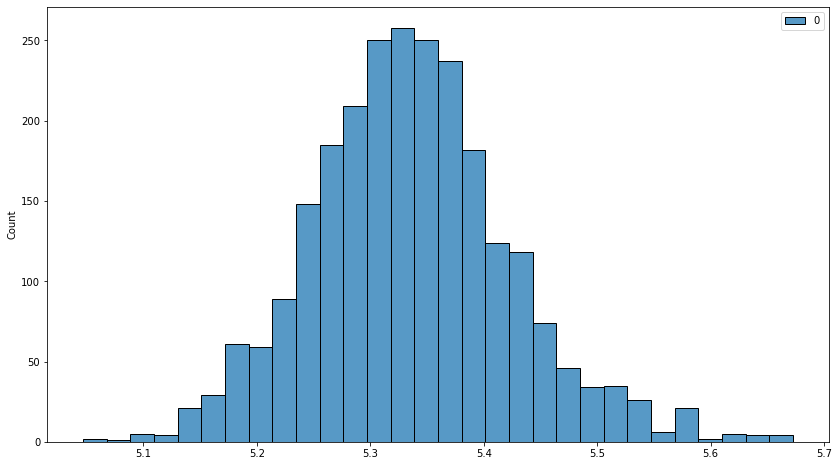

In [77]:
plt.figure(figsize = (14,8))
sns.histplot(sentiment_value.values(), bins = 30, color = "tab:blue")
plt.show

**What are the 10 characters with happiest and saddest pages?**

In [20]:
dict(sorted(sentiment_value.items(), key = itemgetter(1), reverse = True)[:10])

{'Jack B. Quick II': 5.6726016260162595,
 'Super Rabbit': 5.666722090261284,
 'Super-Turtle': 5.657616707616707,
 'Boone, Daniel': 5.656279069767442,
 'Bebe': 5.6444964028776985,
 'Biff Bronson': 5.642165841584159,
 'Bart Regan': 5.63772068511199,
 'Joanie Swift': 5.635828402366863,
 'Rainbow Girl': 5.628080495356037,
 'Buzzy Brown': 5.621750321750322}

In [21]:
dict(sorted(sentiment_value.items(), key = itemgetter(1), reverse = False)[:10])

{'Death Metal': 5.046675257731959,
 'Sin-Eater': 5.062679509632225,
 'Hurricane': 5.082504873294347,
 'Superior': 5.09050185873606,
 'Savage Steel': 5.091127450980393,
 'Death': 5.099054662379421,
 'Clawster': 5.103204225352114,
 'Trash': 5.1047860538827265,
 'Razor Fist': 5.110126582278482,
 'Killer Shrike': 5.111051401869159}

**What are the three happiest communities?**

In [44]:
sentiment_communities = {
                k: np.nanmean(
                    [sentimentcalc(tokenizer.tokenize(super_hero_dict[char]['Wiki_text'].lower())) 
                    for char in v if super_hero_dict[char]['Wiki_text'] is not None]
                            )
                for k, v in communities_dict.items()
                        }

sentiment_communities

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


{0: 5.313776986436285,
 1: 5.32399471545467,
 2: 5.330977832211413,
 3: 5.276096391455473,
 4: 5.321260585623481,
 5: 5.304983802463785,
 6: 5.301979714291702,
 7: 5.311902201967515,
 8: 5.362526514082002,
 9: 5.286384162681617,
 10: 5.298481430066583,
 11: 5.420921568627451,
 12: 5.313885017421603,
 13: nan,
 14: nan,
 15: 5.386773296244785,
 16: nan,
 17: 5.263915999134012,
 18: 5.366507177033493,
 19: 5.268609550561798,
 20: 5.177392795883362}

In [28]:
dict(sorted(sentiment_communities.items(), key = itemgetter(1), reverse = True)[:3])

{11: 5.420921568627451, 8: 5.362526514082002, 2: 5.330977832211413}

**What are the three saddest communities?**

In [29]:
dict(sorted(sentiment_communities.items(), key = itemgetter(1), reverse = False)[:3])

{20: 5.177392795883362, 17: 5.263915999134012, 19: 5.268609550561798}

**Do these results confirm what you can learn about each community by skimming the wikipedia pages?**